In [1]:
# The C2QA package is currently not published to PyPI.
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Cheat to get MS Visual Studio Code Jupyter server to recognize Python venv
module_path = os.path.abspath(os.path.join("../../venv/Lib/site-packages"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import copy
import c2qa
import qiskit
import numpy as np
import scipy
import itertools
import c2qa.util as util
import LGT_resource
import c2qa.stateReadout as stateReadout
import matplotlib.pyplot as plt
import matplotlib
# Import Qiskit
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
from qiskit.providers.aer import AerSimulator
from qiskit import IBMQ
from collections import Counter
import time

In [5]:
num_qubits=2
num_qumodes=2
qubits_per_mode=2
optimizer = 'COBYLA'
num_layers = 2

start = time.time()
out, trace, occ_hist = LGT_resource.schwinger_vqe(num_qubits=num_qubits,
                                     num_qumodes=num_qumodes,
                                     qubits_per_mode=qubits_per_mode,
                                     initial_qumode_state=[2,0],
                                     num_layers=num_layers,
                                     optimizer=optimizer)
print(f'Optimization finished (N_l = {num_layers}): Final energy = {out["fun"]:.3f}')
end = time.time()
print(f'Total runtime: {(end - start):.2f} seconds')

Optimization finished (N_l = 2): Final energy = -4.873
Total runtime: 12.72 seconds


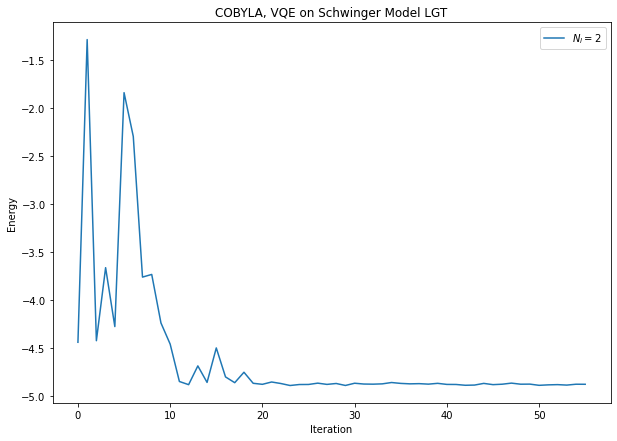

In [6]:
fig, ax = plt.subplots(nrows=1, figsize=[10,7])

ax.plot(list(range(len(trace))), trace, label='$N_l = $' + f'{num_layers}')
    
#ax.axhline(y=-3.78293464, ls='--', c='r')
    
ax.set_title(f'{optimizer}, VQE on Schwinger Model LGT')
ax.set_ylabel('Energy')
ax.set_xlabel('Iteration')
ax.legend()

In [83]:
make_number_operator(c2qa.operators.CVOperators(4, 1).N, 0, 2, 4).size

12

In [127]:
def make_number_operator(matrix, index, num_modes, cutoff):
    identity = scipy.sparse.eye(cutoff)
    if index == 0:
        op = matrix
    else:
        op = identity
    
    for i in range(1, num_modes):
        if i == index:
            op = scipy.sparse.kron(op, matrix)
        else:
            op = scipy.sparse.kron(op, identity)
            
    return op


def measure_electric_contribution(
        circuit: c2qa.CVCircuit,
        qumode_reg: c2qa.QumodeRegister,
        qubit_reg: qiskit.QuantumRegister,
        theta: float,
        ) -> float:
    """Measure the energy of H_E = 1/g * SUM_n{(Na_n - Nb_n - theta / 2pi) ^ 2}"""
    stateop, result = c2qa.util.simulate(circuit)
    
    # Fock counts for each qumode, occupation = [fock_count_qumode_0 , ..., fock_count_qumode_n]
    occupation = c2qa.util.stateread(stateop, qubit_reg.size, qumode_reg.num_qumodes, qumode_reg.cutoff, verbose=False)[0][::-1]
    summation_terms = []
    for n in range(qumode_reg.num_qumodes - 1):
        summation_terms.append(-2 * occupation[n] * occupation[n+1] - theta * (occupation[n] + occupation[n+1]))
        
    qumode_statevector = c2qa.util.cv_partial_trace(circuit, stateop).to_statevector()
    print('qumode statevec')
    print(qumode_statevector)
    
    N_matrix = c2qa.operators.CVOperators(qumode_reg.cutoff, 1).N
    N_squared = N_matrix @ N_matrix
    for index in range(qumode_reg.num_qumodes):
        number_operator = make_number_operator(N_squared, index,
                                               qumode_reg.num_qumodes, qumode_reg.cutoff).toarray()
        
        statevec_dag = qumode_statevector.data.conj().T
        statevec     = qumode_statevector.data
        
        expectation_val = np.dot(statevec_dag, np.dot(number_operator, statevec))
        real_part = np.real(expectation_val)
        imag_part = np.imag(expectation_val)
        if imag_part != 0:
            raise Exception('Imaginary part of expectation value should be 0!')
        summation_terms.append(real_part)

    return sum(summation_terms)

In [128]:
num_qubits=2
num_qumodes=2
qubits_per_mode=2
optimizer = 'COBYLA'
num_layers = 2

qmr = c2qa.QumodeRegister(num_qumodes=num_qumodes, num_qubits_per_qumode=qubits_per_mode)
qbr = qiskit.QuantumRegister(size=num_qubits)
cbr_measure_field = qiskit.ClassicalRegister(size=num_qubits, name='measure_field')
cbr_measure_hopping = qiskit.ClassicalRegister(size=num_qubits, name='measure_hopping')

init_circuit = c2qa.CVCircuit(qmr, qbr, cbr_measure_field, cbr_measure_hopping)

# initialize the qumodes
initial_qumode_state = [2,0]
for i in range(qmr.num_qumodes):
    init_circuit.cv_initialize(initial_qumode_state[i], qmr[i])

measure_electric_contribution(init_circuit, qmr, qbr, 1)

qumode statevec
Statevector([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2))


2.0000000000000018

In [38]:
op = c2qa.operators.CVOperators(qmr.cutoff, qmr.num_qumodes).N
op.toarray()

array([[0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 2., 0.],
       [0., 0., 0., 3.]])